# Kalman filter using theano

В этом ноутбуке мы приведем реализацию фильтра Калмана на theano. Мы будем проводить множественную фильтрацию, когда в наблюдаемая переменная - вектор. В качестве примера использования рассмторим SSM (state space model):

$$y_t = H^{'}_t\xi_t + \epsilon_t$$

$$\xi_{t+1} = F_{t+1}\xi_t + \omega_t$$

Где,

$$\xi_t = \begin{bmatrix}
    \beta_{1t} \\
    l_{1t} \\
    ... \\
    \beta_{nt} \\
    l_{nt}
\end{bmatrix}, \ \ \ \ \
H^{'}_t = \begin{bmatrix}
    x_{1t}       & 1 & 0 & 0 & \dots & 0 & 0 \\
    0       & 0 & x_{2t} & 1 &\dots & 0 & 0\\
    ... \\
    0       & 0 &0 & 0 & \dots & x_{nt} & 1
\end{bmatrix}, \ \ \ \ \
F_{t+1} = \begin{bmatrix}
    1 & 0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 1 & 0 & 0 &\dots & 0 & 0\\
    ... \\
    0 & 0 & 0 & 0 & \dots & 0 & 1
\end{bmatrix}
$$

Эта модель фактически может быть представлена в отдельности для каждой из пар $(x,y)$ в отдельности. Её вид будет таким:

$$y_{i,t} = \beta_{i,t} x_{it} + l_{i,t} + \epsilon_{i,t}$$

$$\beta_{i,t+1} = \beta_{i,t} + u_{i,t}$$

$$l_{i,t+1} = l_{i,}t + v_{i,t}$$



Здесь мы рассматриваем постановку, когда y - вектор по двум причинам:

* Она более общая по сравнению со случаем скалярного y
* Такая постановка позволяет более эффективно по времени решать задачу


------------------------------------------------------------------------------------

__Формат:__

Выходом фильтрации Калмана, являются последовательности

$$\xi_{t+1|t}, \ \ P_{t+1|t}, \ \ \hat{y}_t, \ \ \xi_{t|t}$$

__Важно:__

Прежде чем решать какую-то большу и вычислительно сложную задачу для большого n, поймите какое n наиболее выгодно позволит вам это сделать.

In [1]:
import theano 
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
# for debug: may be useful ->
# -> theano.config.optimizer='None'
# -> theano.config.exception_verbosity='high'

In [142]:
# number of (Y, X) pairs, see the header
n = 7

In [143]:
def simul():
    '''
        simulates X, Y time series from model described in header
        Returns: tuple (y, x)
        
    '''
    N = int(6.5 * 60 * 125)
    beta = 0.5
    x_sigma, beta_sigma, level_sigma, err_sigma = 5., .02, 1., 10.
    x = np.random.randn(N) * x_sigma

    err = np.random.randn(N) * err_sigma
    beta = 1. + np.random.randn(N).cumsum() * beta_sigma
    level = np.random.randn(N).cumsum() * level_sigma
    y = beta*x + level + err
    return y, x

In [144]:
data = [simul() for i in range(n)]
Y = np.hstack([yx[0].reshape(-1, 1) for yx in data]).astype('float32')
X = np.hstack([yx[1].reshape(-1, 1) for yx in data]).astype('float32')

In [145]:
Y.shape, X.shape

((48750, 7), (48750, 7))

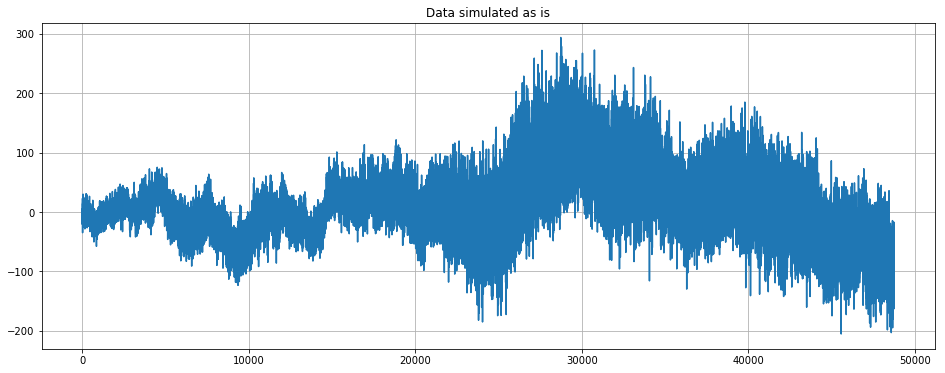

In [146]:
plt.figure(figsize=(16, 6))
plt.grid()
plt.title('Data simulated as is')
plt.plot(Y[:, 0])

In [147]:
def kalman_rec(y_t, H_t, Q_t, R_t, xi_t_tm1, P_t_tm1, F_tp1):
    # for debug: may be useful ->
    # -> print(y_t.ndim, H_t.ndim, F_tp1.ndim, Q_t.ndim, R_t.ndim, xi_t_tm1.ndim, P_t_tm1.ndim)
    
    y_t_hat = T.dot(H_t.T, xi_t_tm1)
    eps_t = y_t - y_t_hat
    pseudo_inv = T.nlinalg.matrix_inverse(T.dot(H_t.T, T.dot(P_t_tm1, H_t)) + R_t)
    invi =  T.dot(P_t_tm1, T.dot(H_t, pseudo_inv))
    xi_t_t = xi_t_tm1 + T.dot(invi, eps_t)
    xi_tp1_t = T.dot(F_tp1, xi_t_t)
    P_t_t = P_t_tm1 - T.dot(invi, T.dot(H_t.T, P_t_tm1))
    P_tp1_t = T.dot(F_tp1, T.dot(P_t_t, F_tp1.T)) + Q_t
    
    return [xi_tp1_t, P_tp1_t, y_t_hat, xi_t_t]

In [148]:
y, H, Q, R = T.tensor3(), T.tensor3(), T.tensor3(), T.tensor3()
F = T.matrix()

In [149]:
sequences=[dict(input=y, taps=[0]), dict(input=H, taps=[0]),\
          dict(input=Q, taps=[0]), dict(input=R, taps=[0])]

In [150]:
xi_1_0 = T.matrix()
P_1_0 = T.matrix()

In [151]:
(values, updates) = theano.scan(fn=kalman_rec,
                                          sequences=sequences,
                                          outputs_info=[xi_1_0, P_1_0, None, None],
                                          non_sequences=[F],
                                          strict=True)

In [152]:
kalman_filter = theano.function([y, H, Q, R, xi_1_0, P_1_0, F], values, updates=updates, allow_input_downcast=True)

In [153]:
def get_G_mat(x):
    G = np.zeros((n, 2*n), dtype='float32')
    source = np.hstack([x.reshape(-1, 1), np.ones((x.shape[0], 1))])
    for i in range(n):
        G[i, i* 2] = source[i, 0]
        G[i, i* 2+1] = source[i, 1]
    return G

In [154]:
# init all variables need
Y = Y[:, :, np.newaxis]
y_val = Y
H_val = np.array([get_G_mat(X[t]).T for t in range(X.shape[0])])
F_val = np.diag(np.ones(2*n, dtype='float32'))
R_val = np.array([10. * np.diag(np.ones(n, dtype='float32')) for t in range(X.shape[0])])
Q_val = np.array([np.diag([0.02, 1.] * n).astype('float32') for t in range(X.shape[0])])

xi_1_0_val = np.zeros((2*n, 1))
P_1_0_val = np.diag(np.ones(2*n))

In [155]:
print('Shapes:\n')
print(' y : {}\n H : {}\n Q : {}\n R : {}\n xi_1_0 : {}\n P_1_0 : {}\n F : {}\n'.format(*map(\
                            lambda d: d.shape, [y_val, H_val, Q_val, R_val, xi_1_0_val, P_1_0_val, F_val])))

Shapes:

 y : (48750, 7, 1)
 H : (48750, 14, 7)
 Q : (48750, 14, 14)
 R : (48750, 7, 7)
 xi_1_0 : (14, 1)
 P_1_0 : (14, 14)
 F : (14, 14)



In [156]:
# speed test
start_time = time.time()

output = kalman_filter(y_val, H_val, Q_val, R_val, xi_1_0_val, P_1_0_val, F_val)

t = time.time() - start_time

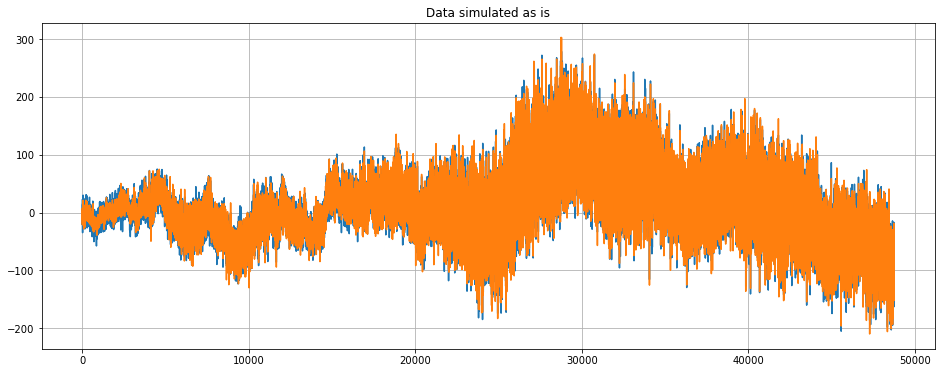

In [157]:
plt.figure(figsize=(16, 6))
plt.grid()
plt.title('Data simulated as is')
plt.plot(Y[:, 0, 0])
plt.plot(np.concatenate(output[-2].T).T[:, 0])

In [116]:
try:
    len(speed_test_data)
except:
    speed_test_data = {}

In [117]:
speed_test_data[n] = t

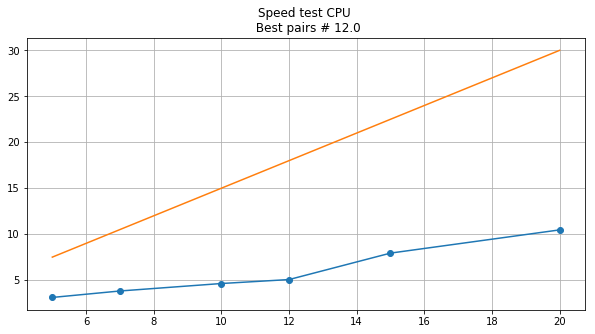

In [118]:
try:
    ns, ts = map(lambda d: np.array(d, dtype='float32'), (list(speed_test_data.keys()), list(speed_test_data.values())))
    ts = ts[ns.argsort()]
    ns.sort()
    ts_numpy =  1.5 * ns

    plt.figure(figsize=(10,5))
    plt.grid()
    plt.plot(ns, ts, 'o-')
    plt.plot(ns, ts_numpy, '-')
    best_n = ns[np.argmin(ts / ts_numpy)]
    plt.title('Speed test CPU \n Best pairs # {}'.format(best_n))
except:
    print('Fill speed test data')